In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


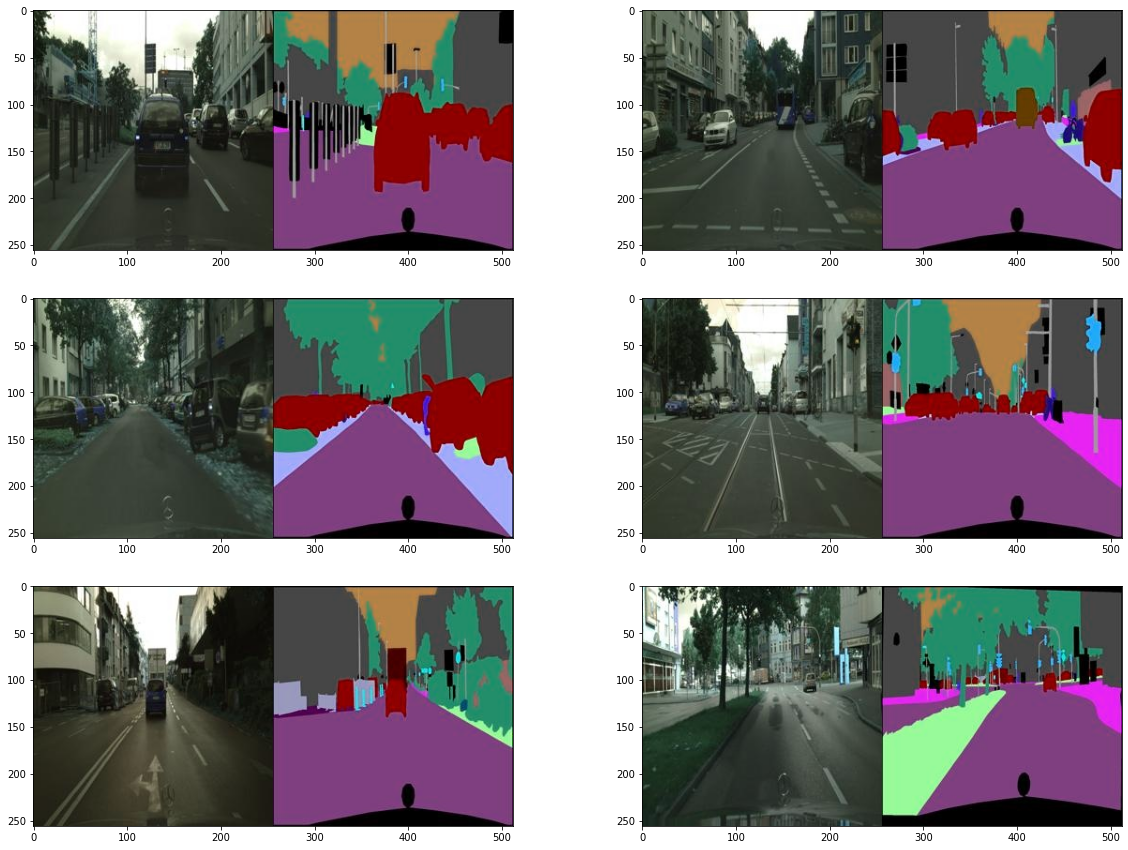

In [2]:
#데이터 확인
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
# 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


# Seg-map / 도로 이미지 분리

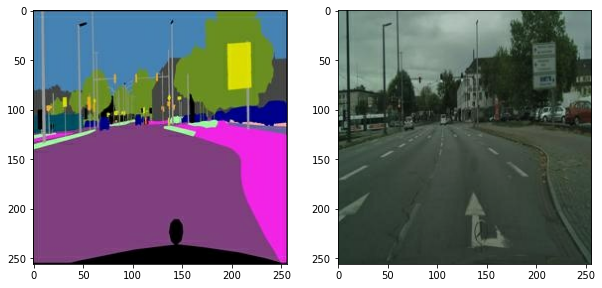

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x): #복원
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32) #
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(seg), normalize(colored)

f = data_path + os.listdir(data_path)[1]
seg, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(seg, colored):
    stacked = tf.concat([seg, colored], axis=-1) #6 channel
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: #50% 확률로 reflection, constant padding 적용
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out) 
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

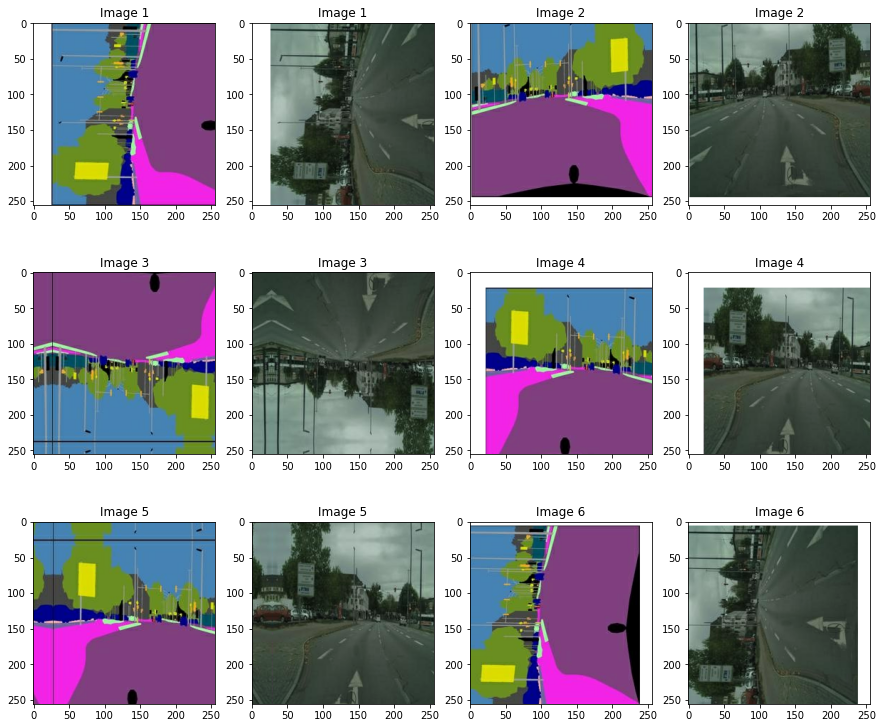

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_colored = apply_augmentation(seg, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

# 전체 데이터셋에 적용

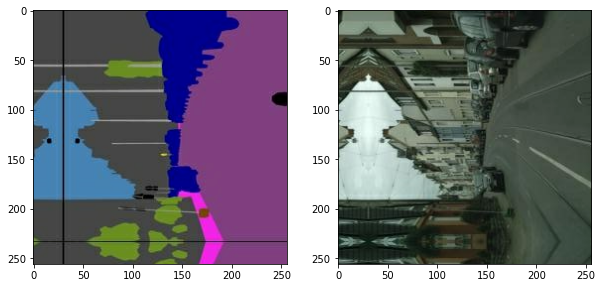

In [7]:
from tensorflow import data

def get_train(img_path):
    seg, colored = load_img(img_path)
    seg, colored = apply_augmentation(seg, colored)
    return seg, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 2. 모델 구성

### U-net based model


#### Generator

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

## U-Net Generator

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] #encoder의 마지막 출력은 skip connection 적용할 필요 없으므로
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): #skip-connection은 뒤 feature 부터 진행되므로
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

#### Discriminator

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [12]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [14]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

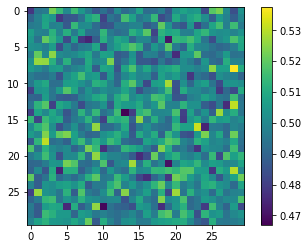

In [15]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 학습 및 테스트하기

#### 손실 함수 정의

In [16]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

#### Optimizer

In [17]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

#### Train_step

In [18]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

#### 학습하기

In [19]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9953                     
L1_loss:0.3079                     
Discriminator_loss:1.2870

EPOCH[1] - STEP[20]                     
Generator_loss:1.0585                     
L1_loss:0.2379                     
Discriminator_loss:1.2326

EPOCH[1] - STEP[30]                     
Generator_loss:0.9064                     
L1_loss:0.2160                     
Discriminator_loss:1.3679

EPOCH[1] - STEP[40]                     
Generator_loss:0.8249                     
L1_loss:0.1964                     
Discriminator_loss:1.2562

EPOCH[1] - STEP[50]                     
Generator_loss:1.0540                     
L1_loss:0.1922                     
Discriminator_loss:1.2828

EPOCH[1] - STEP[60]                     
Generator_loss:0.9557                     
L1_loss:0.2200                     
Discriminator_loss:1.1264

EPOCH[1] - STEP[70]                     
Generator_loss:1.2190                     
L1_loss:0.1793                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.8923                     
L1_loss:0.2219                     
Discriminator_loss:0.4036

EPOCH[3] - STEP[80]                     
Generator_loss:0.8723                     
L1_loss:0.1898                     
Discriminator_loss:0.9304

EPOCH[3] - STEP[90]                     
Generator_loss:2.3809                     
L1_loss:0.1857                     
Discriminator_loss:1.0027

EPOCH[3] - STEP[100]                     
Generator_loss:1.1627                     
L1_loss:0.1794                     
Discriminator_loss:0.6800

EPOCH[3] - STEP[110]                     
Generator_loss:1.9880                     
L1_loss:0.1825                     
Discriminator_loss:0.3441

EPOCH[3] - STEP[120]                     
Generator_loss:1.6774                     
L1_loss:0.1519                     
Discriminator_loss:1.3539

EPOCH[3] - STEP[130]                     
Generator_loss:1.1626                     
L1_loss:0.1897                

EPOCH[5] - STEP[130]                     
Generator_loss:0.2611                     
L1_loss:0.1959                     
Discriminator_loss:1.8202

EPOCH[5] - STEP[140]                     
Generator_loss:1.0841                     
L1_loss:0.1651                     
Discriminator_loss:0.7681

EPOCH[5] - STEP[150]                     
Generator_loss:0.7897                     
L1_loss:0.1762                     
Discriminator_loss:0.8992

EPOCH[5] - STEP[160]                     
Generator_loss:0.3422                     
L1_loss:0.2103                     
Discriminator_loss:1.4536

EPOCH[5] - STEP[170]                     
Generator_loss:0.7502                     
L1_loss:0.2167                     
Discriminator_loss:0.8032

EPOCH[5] - STEP[180]                     
Generator_loss:0.8467                     
L1_loss:0.1862                     
Discriminator_loss:0.7815

EPOCH[5] - STEP[190]                     
Generator_loss:0.5399                     
L1_loss:0.1711             

EPOCH[7] - STEP[190]                     
Generator_loss:2.2419                     
L1_loss:0.1892                     
Discriminator_loss:0.2001

EPOCH[7] - STEP[200]                     
Generator_loss:1.2353                     
L1_loss:0.1901                     
Discriminator_loss:0.4629

EPOCH[7] - STEP[210]                     
Generator_loss:1.0672                     
L1_loss:0.2281                     
Discriminator_loss:1.9552

EPOCH[7] - STEP[220]                     
Generator_loss:1.6347                     
L1_loss:0.1614                     
Discriminator_loss:0.4747

EPOCH[7] - STEP[230]                     
Generator_loss:3.1425                     
L1_loss:0.1753                     
Discriminator_loss:2.0855

EPOCH[7] - STEP[240]                     
Generator_loss:0.6376                     
L1_loss:0.1827                     
Discriminator_loss:1.0235

EPOCH[7] - STEP[250]                     
Generator_loss:2.1149                     
L1_loss:0.1713             

EPOCH[9] - STEP[250]                     
Generator_loss:1.1578                     
L1_loss:0.1598                     
Discriminator_loss:0.6524

EPOCH[10] - STEP[10]                     
Generator_loss:0.7441                     
L1_loss:0.1876                     
Discriminator_loss:1.2510

EPOCH[10] - STEP[20]                     
Generator_loss:0.3189                     
L1_loss:0.1651                     
Discriminator_loss:2.5073

EPOCH[10] - STEP[30]                     
Generator_loss:0.2653                     
L1_loss:0.2030                     
Discriminator_loss:1.6287

EPOCH[10] - STEP[40]                     
Generator_loss:0.0813                     
L1_loss:0.1577                     
Discriminator_loss:3.1101

EPOCH[10] - STEP[50]                     
Generator_loss:1.3268                     
L1_loss:0.1893                     
Discriminator_loss:0.4629

EPOCH[10] - STEP[60]                     
Generator_loss:0.7452                     
L1_loss:0.1982             

EPOCH[12] - STEP[60]                     
Generator_loss:1.8251                     
L1_loss:0.1848                     
Discriminator_loss:0.3557

EPOCH[12] - STEP[70]                     
Generator_loss:0.5545                     
L1_loss:0.1585                     
Discriminator_loss:1.0826

EPOCH[12] - STEP[80]                     
Generator_loss:0.9702                     
L1_loss:0.1742                     
Discriminator_loss:0.7346

EPOCH[12] - STEP[90]                     
Generator_loss:0.9136                     
L1_loss:0.1691                     
Discriminator_loss:2.0563

EPOCH[12] - STEP[100]                     
Generator_loss:0.8685                     
L1_loss:0.1779                     
Discriminator_loss:0.8743

EPOCH[12] - STEP[110]                     
Generator_loss:1.0022                     
L1_loss:0.1995                     
Discriminator_loss:1.0267

EPOCH[12] - STEP[120]                     
Generator_loss:0.6862                     
L1_loss:0.2183          

EPOCH[14] - STEP[120]                     
Generator_loss:1.8684                     
L1_loss:0.1489                     
Discriminator_loss:1.0421

EPOCH[14] - STEP[130]                     
Generator_loss:2.9551                     
L1_loss:0.1752                     
Discriminator_loss:0.6870

EPOCH[14] - STEP[140]                     
Generator_loss:0.5262                     
L1_loss:0.1715                     
Discriminator_loss:1.3282

EPOCH[14] - STEP[150]                     
Generator_loss:1.5702                     
L1_loss:0.1686                     
Discriminator_loss:0.5826

EPOCH[14] - STEP[160]                     
Generator_loss:1.7272                     
L1_loss:0.1827                     
Discriminator_loss:1.1990

EPOCH[14] - STEP[170]                     
Generator_loss:1.5705                     
L1_loss:0.1994                     
Discriminator_loss:0.3919

EPOCH[14] - STEP[180]                     
Generator_loss:2.4696                     
L1_loss:0.1643      

EPOCH[16] - STEP[180]                     
Generator_loss:0.6170                     
L1_loss:0.1475                     
Discriminator_loss:1.2207

EPOCH[16] - STEP[190]                     
Generator_loss:1.6686                     
L1_loss:0.1678                     
Discriminator_loss:0.5907

EPOCH[16] - STEP[200]                     
Generator_loss:1.3856                     
L1_loss:0.1642                     
Discriminator_loss:0.4561

EPOCH[16] - STEP[210]                     
Generator_loss:1.2647                     
L1_loss:0.2159                     
Discriminator_loss:0.5812

EPOCH[16] - STEP[220]                     
Generator_loss:1.3901                     
L1_loss:0.1839                     
Discriminator_loss:1.3860

EPOCH[16] - STEP[230]                     
Generator_loss:1.3853                     
L1_loss:0.1721                     
Discriminator_loss:1.1845

EPOCH[16] - STEP[240]                     
Generator_loss:1.0945                     
L1_loss:0.2083      

EPOCH[18] - STEP[240]                     
Generator_loss:2.3857                     
L1_loss:0.1586                     
Discriminator_loss:1.7752

EPOCH[18] - STEP[250]                     
Generator_loss:1.9058                     
L1_loss:0.1655                     
Discriminator_loss:1.0401

EPOCH[19] - STEP[10]                     
Generator_loss:1.6014                     
L1_loss:0.1800                     
Discriminator_loss:0.4516

EPOCH[19] - STEP[20]                     
Generator_loss:1.0071                     
L1_loss:0.1587                     
Discriminator_loss:1.1607

EPOCH[19] - STEP[30]                     
Generator_loss:2.3370                     
L1_loss:0.1982                     
Discriminator_loss:0.3981

EPOCH[19] - STEP[40]                     
Generator_loss:2.0045                     
L1_loss:0.1932                     
Discriminator_loss:0.8039

EPOCH[19] - STEP[50]                     
Generator_loss:1.9840                     
L1_loss:0.2041           

EPOCH[21] - STEP[50]                     
Generator_loss:0.6712                     
L1_loss:0.2081                     
Discriminator_loss:0.8080

EPOCH[21] - STEP[60]                     
Generator_loss:1.1395                     
L1_loss:0.1798                     
Discriminator_loss:0.8843

EPOCH[21] - STEP[70]                     
Generator_loss:1.5886                     
L1_loss:0.1923                     
Discriminator_loss:0.4387

EPOCH[21] - STEP[80]                     
Generator_loss:1.8613                     
L1_loss:0.2235                     
Discriminator_loss:0.6538

EPOCH[21] - STEP[90]                     
Generator_loss:1.7474                     
L1_loss:0.2054                     
Discriminator_loss:0.4348

EPOCH[21] - STEP[100]                     
Generator_loss:1.1886                     
L1_loss:0.1578                     
Discriminator_loss:2.7371

EPOCH[21] - STEP[110]                     
Generator_loss:1.6306                     
L1_loss:0.1687           

EPOCH[23] - STEP[110]                     
Generator_loss:1.5624                     
L1_loss:0.1968                     
Discriminator_loss:0.6452

EPOCH[23] - STEP[120]                     
Generator_loss:1.1086                     
L1_loss:0.2092                     
Discriminator_loss:0.5113

EPOCH[23] - STEP[130]                     
Generator_loss:2.1581                     
L1_loss:0.1687                     
Discriminator_loss:0.4585

EPOCH[23] - STEP[140]                     
Generator_loss:0.4963                     
L1_loss:0.1833                     
Discriminator_loss:1.1582

EPOCH[23] - STEP[150]                     
Generator_loss:2.2206                     
L1_loss:0.1474                     
Discriminator_loss:0.6733

EPOCH[23] - STEP[160]                     
Generator_loss:1.1468                     
L1_loss:0.1732                     
Discriminator_loss:0.6450

EPOCH[23] - STEP[170]                     
Generator_loss:0.9683                     
L1_loss:0.1792      

EPOCH[25] - STEP[170]                     
Generator_loss:1.9054                     
L1_loss:0.1619                     
Discriminator_loss:0.4273

EPOCH[25] - STEP[180]                     
Generator_loss:0.4656                     
L1_loss:0.1490                     
Discriminator_loss:1.2204

EPOCH[25] - STEP[190]                     
Generator_loss:1.2714                     
L1_loss:0.1758                     
Discriminator_loss:0.5888

EPOCH[25] - STEP[200]                     
Generator_loss:0.5914                     
L1_loss:0.1862                     
Discriminator_loss:1.1288

EPOCH[25] - STEP[210]                     
Generator_loss:1.8304                     
L1_loss:0.1852                     
Discriminator_loss:0.9028

EPOCH[25] - STEP[220]                     
Generator_loss:1.3105                     
L1_loss:0.1465                     
Discriminator_loss:1.2251

EPOCH[25] - STEP[230]                     
Generator_loss:1.8520                     
L1_loss:0.1477      

EPOCH[27] - STEP[230]                     
Generator_loss:2.1481                     
L1_loss:0.1666                     
Discriminator_loss:0.9983

EPOCH[27] - STEP[240]                     
Generator_loss:1.3116                     
L1_loss:0.1840                     
Discriminator_loss:0.4414

EPOCH[27] - STEP[250]                     
Generator_loss:2.6115                     
L1_loss:0.1997                     
Discriminator_loss:0.4511

EPOCH[28] - STEP[10]                     
Generator_loss:2.3766                     
L1_loss:0.1610                     
Discriminator_loss:0.9467

EPOCH[28] - STEP[20]                     
Generator_loss:2.2531                     
L1_loss:0.1609                     
Discriminator_loss:1.3853

EPOCH[28] - STEP[30]                     
Generator_loss:2.0029                     
L1_loss:0.1548                     
Discriminator_loss:1.4498

EPOCH[28] - STEP[40]                     
Generator_loss:1.9917                     
L1_loss:0.1647          

EPOCH[30] - STEP[40]                     
Generator_loss:0.9371                     
L1_loss:0.1732                     
Discriminator_loss:2.0271

EPOCH[30] - STEP[50]                     
Generator_loss:1.7143                     
L1_loss:0.1604                     
Discriminator_loss:1.3277

EPOCH[30] - STEP[60]                     
Generator_loss:0.6635                     
L1_loss:0.1997                     
Discriminator_loss:1.1123

EPOCH[30] - STEP[70]                     
Generator_loss:0.6328                     
L1_loss:0.1874                     
Discriminator_loss:1.7568

EPOCH[30] - STEP[80]                     
Generator_loss:2.5458                     
L1_loss:0.1606                     
Discriminator_loss:0.5337

EPOCH[30] - STEP[90]                     
Generator_loss:1.1160                     
L1_loss:0.2175                     
Discriminator_loss:0.8861

EPOCH[30] - STEP[100]                     
Generator_loss:0.7271                     
L1_loss:0.1946            

EPOCH[32] - STEP[100]                     
Generator_loss:1.2075                     
L1_loss:0.1828                     
Discriminator_loss:0.5931

EPOCH[32] - STEP[110]                     
Generator_loss:1.4353                     
L1_loss:0.1700                     
Discriminator_loss:1.7303

EPOCH[32] - STEP[120]                     
Generator_loss:1.5386                     
L1_loss:0.1659                     
Discriminator_loss:1.0690

EPOCH[32] - STEP[130]                     
Generator_loss:1.9235                     
L1_loss:0.1976                     
Discriminator_loss:0.2335

EPOCH[32] - STEP[140]                     
Generator_loss:1.2734                     
L1_loss:0.1813                     
Discriminator_loss:0.4617

EPOCH[32] - STEP[150]                     
Generator_loss:1.6243                     
L1_loss:0.1895                     
Discriminator_loss:0.3459

EPOCH[32] - STEP[160]                     
Generator_loss:0.8238                     
L1_loss:0.1753      

EPOCH[34] - STEP[160]                     
Generator_loss:1.1646                     
L1_loss:0.2072                     
Discriminator_loss:0.6545

EPOCH[34] - STEP[170]                     
Generator_loss:1.6968                     
L1_loss:0.1765                     
Discriminator_loss:0.7300

EPOCH[34] - STEP[180]                     
Generator_loss:1.6830                     
L1_loss:0.1845                     
Discriminator_loss:1.7903

EPOCH[34] - STEP[190]                     
Generator_loss:1.9115                     
L1_loss:0.2013                     
Discriminator_loss:0.2825

EPOCH[34] - STEP[200]                     
Generator_loss:0.6324                     
L1_loss:0.1675                     
Discriminator_loss:1.2549

EPOCH[34] - STEP[210]                     
Generator_loss:1.2909                     
L1_loss:0.1547                     
Discriminator_loss:1.2074

EPOCH[34] - STEP[220]                     
Generator_loss:0.8779                     
L1_loss:0.1572      

EPOCH[36] - STEP[220]                     
Generator_loss:2.2423                     
L1_loss:0.1702                     
Discriminator_loss:0.2159

EPOCH[36] - STEP[230]                     
Generator_loss:1.3966                     
L1_loss:0.1845                     
Discriminator_loss:0.8498

EPOCH[36] - STEP[240]                     
Generator_loss:1.9220                     
L1_loss:0.1867                     
Discriminator_loss:0.3192

EPOCH[36] - STEP[250]                     
Generator_loss:2.2075                     
L1_loss:0.1660                     
Discriminator_loss:1.8831

EPOCH[37] - STEP[10]                     
Generator_loss:1.2579                     
L1_loss:0.1597                     
Discriminator_loss:0.6103

EPOCH[37] - STEP[20]                     
Generator_loss:0.8971                     
L1_loss:0.1995                     
Discriminator_loss:0.5998

EPOCH[37] - STEP[30]                     
Generator_loss:1.4571                     
L1_loss:0.1856         

EPOCH[39] - STEP[30]                     
Generator_loss:1.7916                     
L1_loss:0.1660                     
Discriminator_loss:1.0926

EPOCH[39] - STEP[40]                     
Generator_loss:1.8392                     
L1_loss:0.1794                     
Discriminator_loss:0.8963

EPOCH[39] - STEP[50]                     
Generator_loss:0.7758                     
L1_loss:0.1902                     
Discriminator_loss:0.9394

EPOCH[39] - STEP[60]                     
Generator_loss:0.7876                     
L1_loss:0.1670                     
Discriminator_loss:0.8176

EPOCH[39] - STEP[70]                     
Generator_loss:2.2216                     
L1_loss:0.1746                     
Discriminator_loss:0.1973

EPOCH[39] - STEP[80]                     
Generator_loss:0.6596                     
L1_loss:0.1759                     
Discriminator_loss:1.0926

EPOCH[39] - STEP[90]                     
Generator_loss:1.3829                     
L1_loss:0.1601             

EPOCH[41] - STEP[90]                     
Generator_loss:2.0814                     
L1_loss:0.1765                     
Discriminator_loss:2.0116

EPOCH[41] - STEP[100]                     
Generator_loss:0.6560                     
L1_loss:0.1575                     
Discriminator_loss:0.9699

EPOCH[41] - STEP[110]                     
Generator_loss:1.4095                     
L1_loss:0.2094                     
Discriminator_loss:0.3471

EPOCH[41] - STEP[120]                     
Generator_loss:1.1942                     
L1_loss:0.2114                     
Discriminator_loss:0.4540

EPOCH[41] - STEP[130]                     
Generator_loss:0.2849                     
L1_loss:0.1594                     
Discriminator_loss:1.8343

EPOCH[41] - STEP[140]                     
Generator_loss:1.1828                     
L1_loss:0.1571                     
Discriminator_loss:0.7312

EPOCH[41] - STEP[150]                     
Generator_loss:0.7930                     
L1_loss:0.1865       

EPOCH[45] - STEP[170]                     
Generator_loss:1.4566                     
L1_loss:0.1523                     
Discriminator_loss:1.3443

EPOCH[45] - STEP[180]                     
Generator_loss:0.9801                     
L1_loss:0.1833                     
Discriminator_loss:0.5372

EPOCH[45] - STEP[190]                     
Generator_loss:1.4249                     
L1_loss:0.1523                     
Discriminator_loss:0.4977

EPOCH[45] - STEP[200]                     
Generator_loss:0.4988                     
L1_loss:0.2049                     
Discriminator_loss:1.0365

EPOCH[45] - STEP[210]                     
Generator_loss:1.3942                     
L1_loss:0.1523                     
Discriminator_loss:1.9671

EPOCH[45] - STEP[220]                     
Generator_loss:0.6927                     
L1_loss:0.1794                     
Discriminator_loss:1.1178

EPOCH[45] - STEP[230]                     
Generator_loss:1.3207                     
L1_loss:0.2211      

EPOCH[47] - STEP[230]                     
Generator_loss:1.4720                     
L1_loss:0.1568                     
Discriminator_loss:0.7414

EPOCH[47] - STEP[240]                     
Generator_loss:1.6049                     
L1_loss:0.1767                     
Discriminator_loss:0.4253

EPOCH[47] - STEP[250]                     
Generator_loss:1.9864                     
L1_loss:0.2000                     
Discriminator_loss:0.3833

EPOCH[48] - STEP[10]                     
Generator_loss:0.9446                     
L1_loss:0.2016                     
Discriminator_loss:0.6063

EPOCH[48] - STEP[20]                     
Generator_loss:2.8902                     
L1_loss:0.1681                     
Discriminator_loss:0.8635

EPOCH[48] - STEP[30]                     
Generator_loss:1.3624                     
L1_loss:0.1805                     
Discriminator_loss:0.7210

EPOCH[48] - STEP[40]                     
Generator_loss:1.8580                     
L1_loss:0.1852          

EPOCH[50] - STEP[40]                     
Generator_loss:1.5749                     
L1_loss:0.1744                     
Discriminator_loss:0.4720

EPOCH[50] - STEP[50]                     
Generator_loss:1.1048                     
L1_loss:0.1805                     
Discriminator_loss:0.5362

EPOCH[50] - STEP[60]                     
Generator_loss:0.9422                     
L1_loss:0.1756                     
Discriminator_loss:0.8737

EPOCH[50] - STEP[70]                     
Generator_loss:1.1275                     
L1_loss:0.1617                     
Discriminator_loss:1.3871

EPOCH[50] - STEP[80]                     
Generator_loss:0.7700                     
L1_loss:0.1828                     
Discriminator_loss:0.8017

EPOCH[50] - STEP[90]                     
Generator_loss:1.6009                     
L1_loss:0.2269                     
Discriminator_loss:0.2663

EPOCH[50] - STEP[100]                     
Generator_loss:1.1745                     
L1_loss:0.1746            

#### 이미지 생성하기

In [20]:
valid_dir = os.getenv("HOME")+'/aiffel/conditional_generation/data/cityscapes/val/'

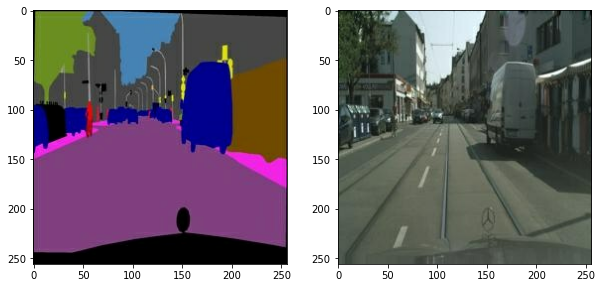

In [21]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x): #복원
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32) #
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(seg), normalize(colored)

f = valid_dir + os.listdir(valid_dir)[0]
seg, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

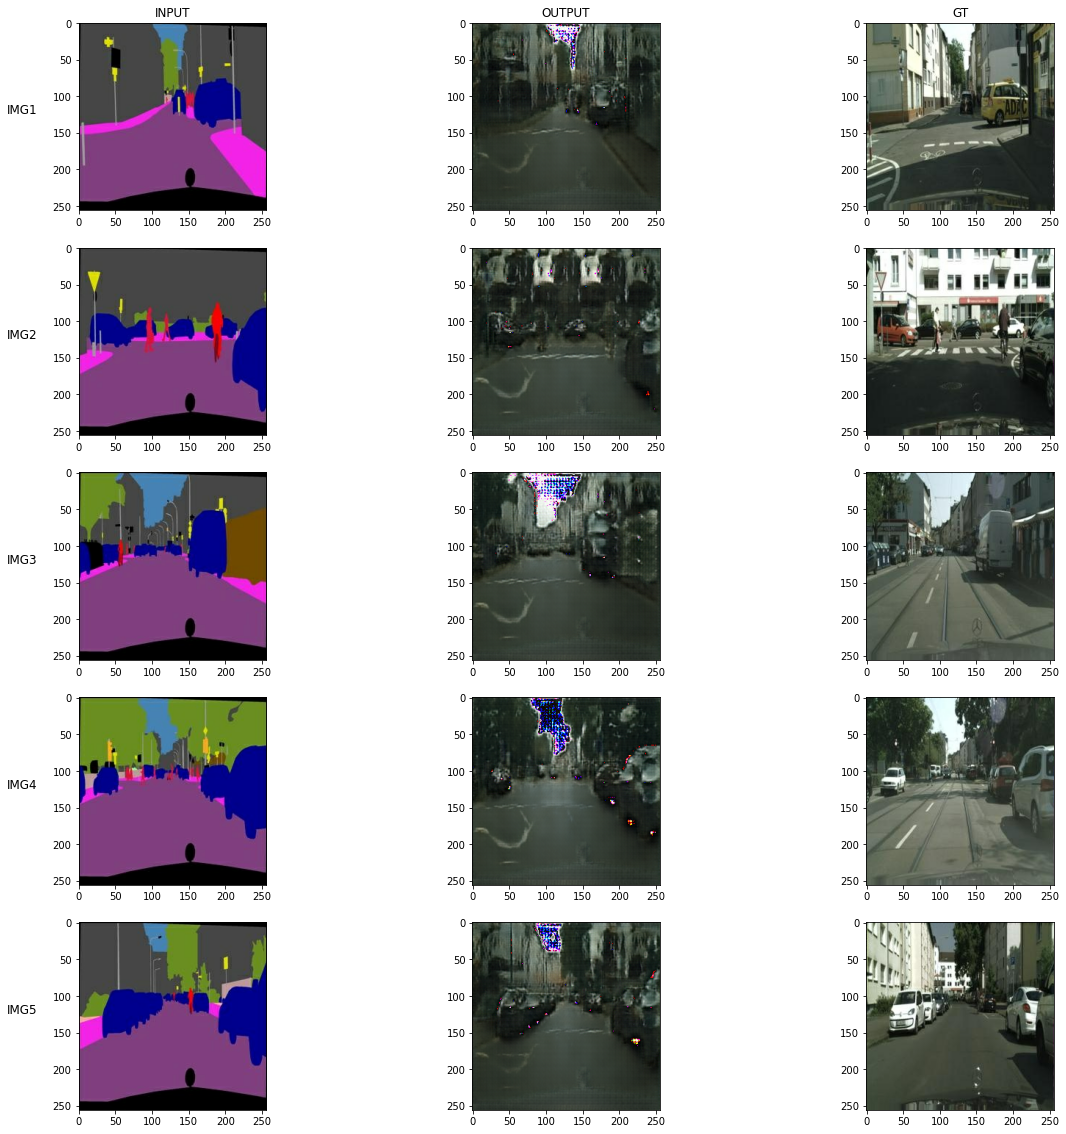

In [22]:
valid_images = data.Dataset.list_files(valid_dir+ "*.jpg")
valid_images = valid_images.map(load_img)

fig,axes = plt.subplots(5,3,figsize=(20,20))

cols = ['INPUT','OUTPUT','GT'] #col 이름
rows = ['IMG1','IMG2','IMG3','IMG4','IMG5'] #row 이름

for i,(seg,colored) in enumerate(valid_images): 
    
    pred = generator(tf.expand_dims(seg, 0))
    pred = denormalize(pred)
    row, col = i, 0
    
    axes[row][col].imshow(denormalize(seg))
    axes[row][col+1].imshow(pred[0])
    axes[row][col+2].imshow(denormalize(colored))
    

for ax, col in zip(axes[0], cols): #columns 공통 이름 설정
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows): #rows 공통 이름 설정
    ax.set_ylabel(row, labelpad=30,rotation=0, size='large')
    
plt.show()

# 회고

에폭을 10,50 두 번 돌려봤는데 별로 큰 차이는 나지 않는 것 같다,,

GAN을 학습 시킬 때는 에폭이 큰 영향을 끼치지는 않는 것 같다.

그래도 전에 DCGAN을 공부할 때는 결과물이 엄청 안좋았는데

이번에는 형체는 알아볼 수 있게 나왔다.